<a href="https://colab.research.google.com/github/mahmoudta74/FIDVR/blob/main/Copy_of_FIDVR_khorasan_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
%matplotlib inline
from IPython.display import display, clear_output
import pandas as pd
import time
import json

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.optim as optim

torch.set_printoptions(linewidth=120) #Disply Option for output
torch.set_grad_enabled(True)          # already on by default\


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


font1 = {'family': 'serif',
        'color':  'darkgreen',
        'weight': 'normal',
        'size': 18,
        }


font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13,
        }


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class Network(nn.Module):

    def __init__(self, n_features, n_hidden, n_layers):
        super(Network, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size= n_features, hidden_size= n_hidden,
                             num_layers = n_layers, batch_first = True,
                             dropout = 0.4
                             )
            

        self.linear1 = nn.Linear(in_features= n_hidden, out_features= 5)
        self.linear2 = nn.Linear(in_features= 5, out_features= 1)
        #self.linear3 = nn.Linear(in_features= 5, out_features= 1)

    def forward(self, x):

        h0 = torch.randn(self.n_layers, x.size(0), self.n_hidden).to('cuda')  # (batch_size= x.size(0) )
        c0 = torch.randn(self.n_layers, x.size(0), self.n_hidden).to('cuda')
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear1(hn[-1])
        out = self.linear2(out)
        #out = self.linear3(out)

        return out

In [5]:
network = torch.load('/content/drive/MyDrive/FIDVR_model_results/0.1/0.4_5_2048_200_1/model2.ckpt')

In [13]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_sim_1.csv')
data = df.to_numpy()
t = data[:, 0]

In [14]:
Predictions = []
Rs_JAD = []

for i in range(123+61, 123+61+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[15])
    tst_i = torch.tensor(Rs_i[0:18], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)
        

In [15]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [16]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+61+Load_shedding_bus])
Load_shedding_bus

index_fldkhsn3


8

In [ ]:
Ri

array([-0.53297513, -1.02522558, -0.51655277, -0.6048352 , -1.0724512 ,
        0.16295346, -0.58006788, -0.85912467, -1.48172446, -0.8190404 ,
       -0.1362456 , -0.65693464,  0.22620399, -0.44588867, -0.8602991 ,
       -0.59427411, -0.58651708, -1.05117977,  0.15327762,  0.21129018,
        0.19163985, -0.40297493,  0.04458518, -0.54105168, -0.08784113,
        0.27303083, -0.27077443, -1.07481265, -0.48763422, -0.14115774,
       -0.65702257, -0.7792799 , -1.04211685, -0.60833252,  0.1598161 ,
       -0.89264572, -0.51364902, -0.45444795, -0.99854296, -0.69621636,
       -1.09030973,  0.34780306, -0.71171526, -0.81877262, -0.27709517,
       -0.80005055, -0.92205149, -0.21301144, -0.05853775, -0.54829319,
       -0.29063536, -0.27240343, -0.39386679, -0.37651113, -0.92026054,
        0.19719595,  0.34593555,  0.3558222 , -0.89341757, -1.07271878,
       -0.7810831 ])

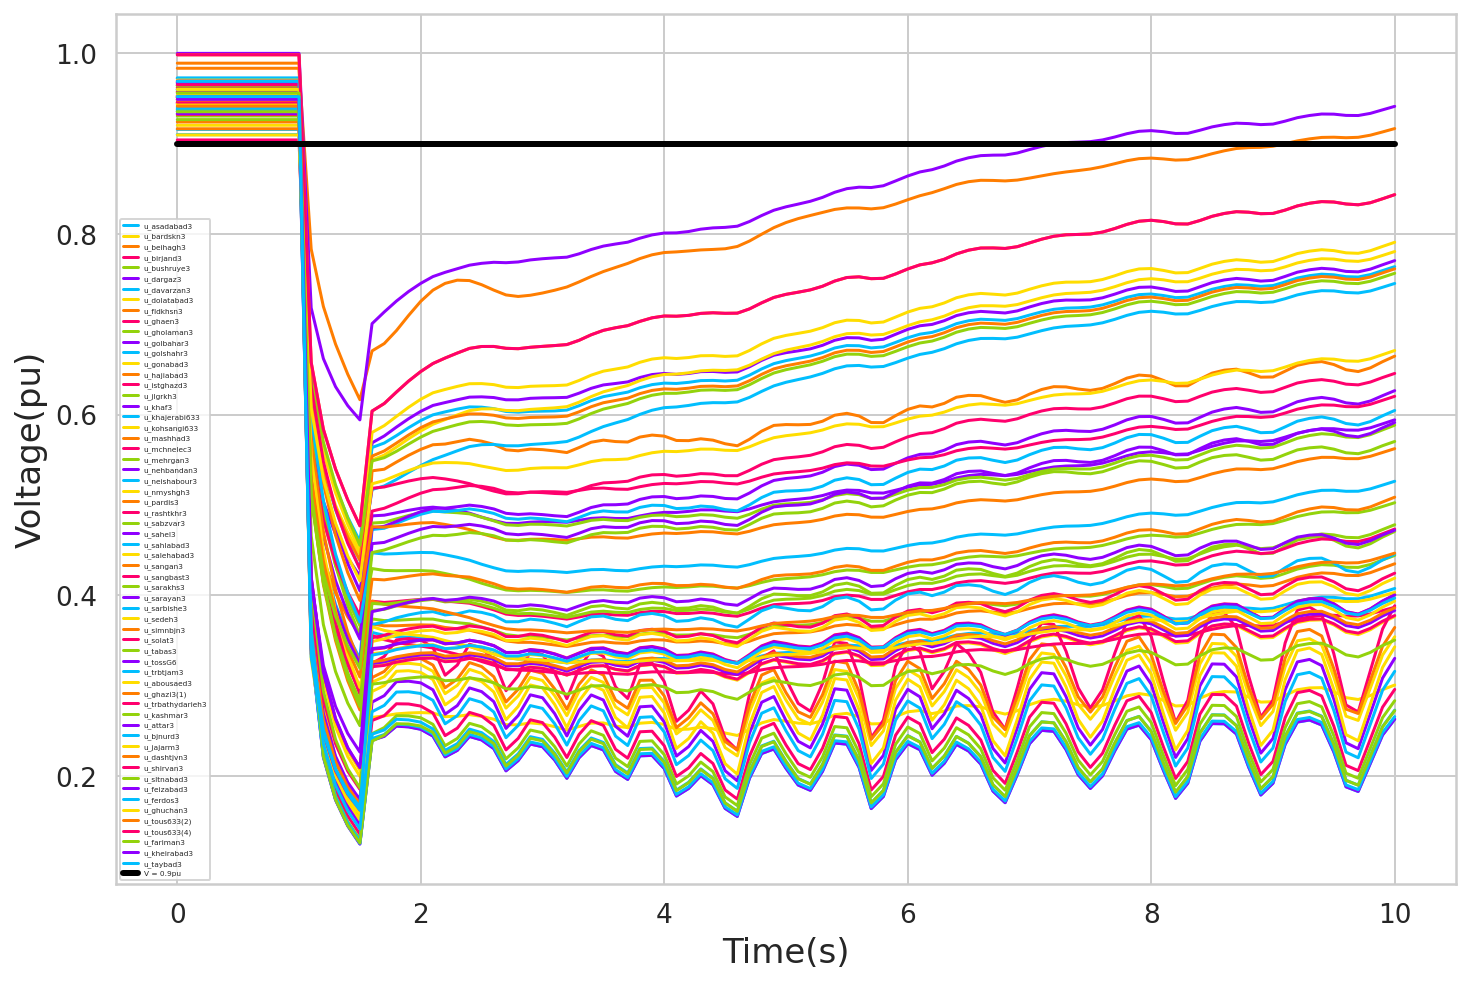

In [ ]:
plt.figure(figsize=(12,8))

for i in range(1, 123+61, 3):
    plt.plot(t[0:101], data[0:101,i], label=df.columns[i] )

'''
plt.annotate('(3.1, 0.9)', xy =(3.1, 0.9),
                xytext =(4, 0.6),  fontsize=15 ,
                arrowprops = dict(facecolor ='black',
                 shrink = 0.05))
'''
plt.plot(t[0:101], 0.9*np.ones((101)), c='black', label='V = 0.9pu', linewidth=3)
#plt.scatter(3.12, 0.9, c='black', s=75)
plt.xlabel('Time(s)', fontsize=17)
plt.ylabel('Voltage(pu)', fontsize=17)
plt.legend(fontsize=3.7)
plt.savefig('unstable_voltage.png', format='png' ,dpi=800)

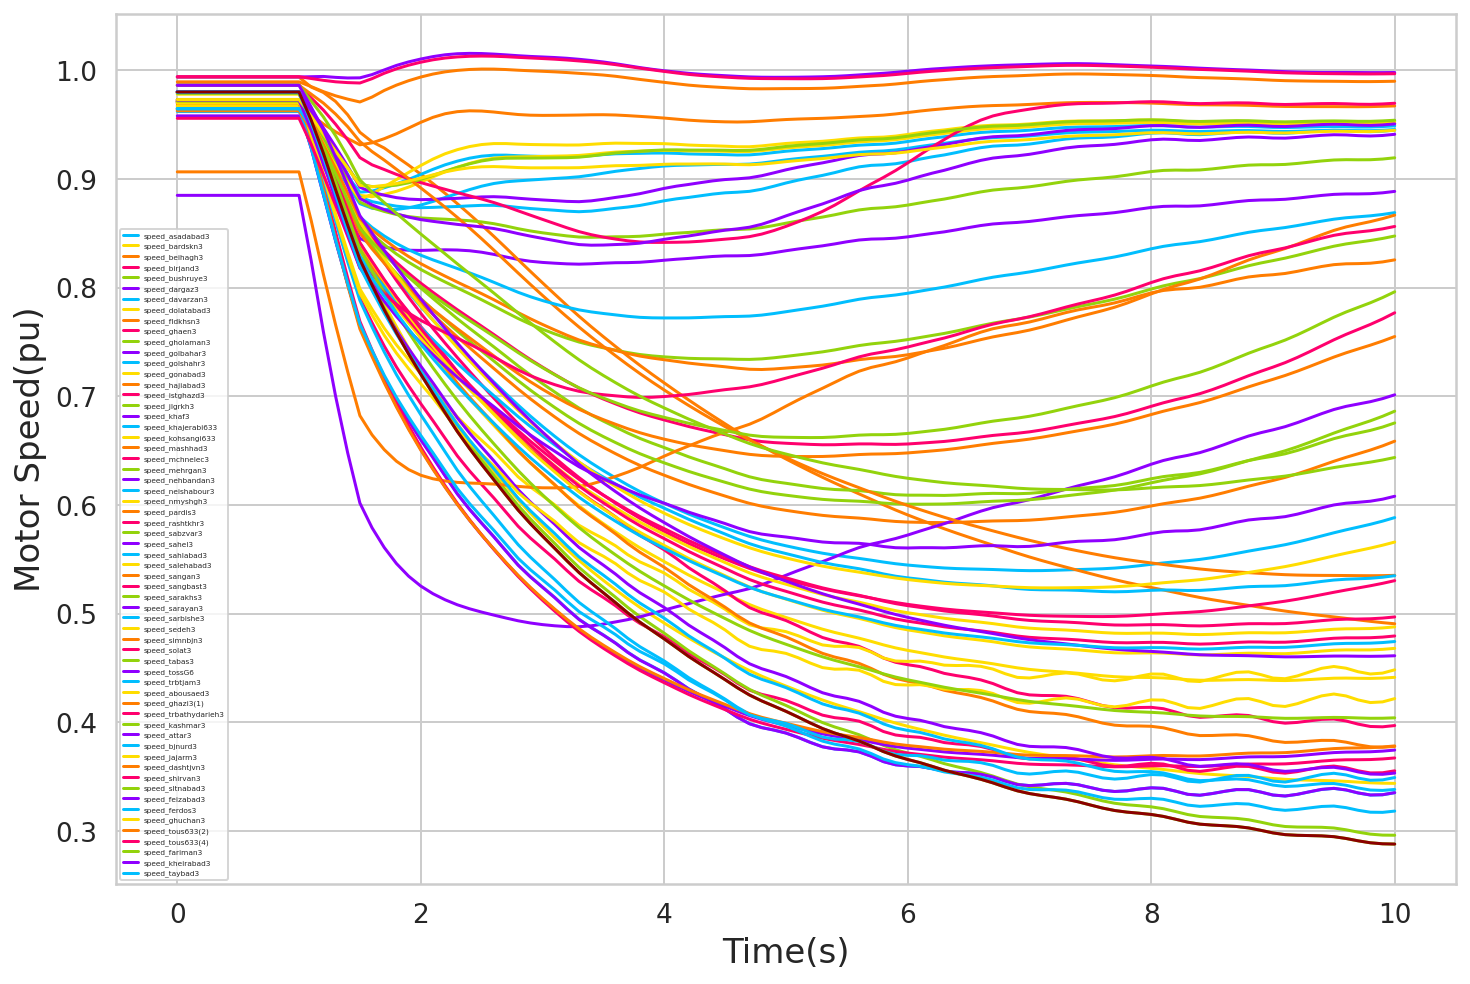

In [ ]:
plt.figure(figsize=(12,8))

for i in range(3, 123+61, 3):
    plt.plot(t[0:101], data[0:101,i], label=df.columns[i])


plt.xlabel('Time(s)', fontsize=17)
plt.ylabel('Motor Speed(pu)', fontsize=17)
plt.plot(t[0:101], data[0:101,123], c='darkred')
plt.legend(fontsize=3.7)
plt.savefig('unstable_speed.png', format='png' ,dpi=600)

In [1]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_sim_2.csv')
data = df.to_numpy()

NameError: ignored

In [ ]:
Predictions = []
Rs_JAD = []

for i in range(123, 123+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[17])
    tst_i = torch.tensor(Rs_i[2:20], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)

In [ ]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [ ]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+Load_shedding_bus])
Load_shedding_bus

index_bardskn3


1

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_sim_3.csv')
data = df.to_numpy()

In [ ]:
Predictions = []
Rs_JAD = []

for i in range(123, 123+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[19])
    tst_i = torch.tensor(Rs_i[4:22], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)
        

In [ ]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [ ]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+Load_shedding_bus])
Load_shedding_bus

index_bushruye3


4

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_sim_4.csv')
data = df.to_numpy()

In [ ]:
Predictions = []
Rs_JAD = []

for i in range(123, 123+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[21])
    tst_i = torch.tensor(Rs_i[6:24], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)
        

In [ ]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [ ]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+Load_shedding_bus])
Load_shedding_bus

index_kheirabad3


59

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_sim_5.csv')
data = df.to_numpy()

In [ ]:
Predictions = []
Rs_JAD = []

for i in range(123, 123+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[23])
    tst_i = torch.tensor(Rs_i[8:26], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)
        

In [ ]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [ ]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+Load_shedding_bus])
Load_shedding_bus

index_khaf3


17

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_sim_6.csv')
data = df.to_numpy()
t = data[:, 0]

In [ ]:
Predictions = []
Rs_JAD = []

for i in range(123, 123+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[25])
    tst_i = torch.tensor(Rs_i[10:28], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)
        

In [ ]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [ ]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+Load_shedding_bus])
Load_shedding_bus

index_hajiabad3


14

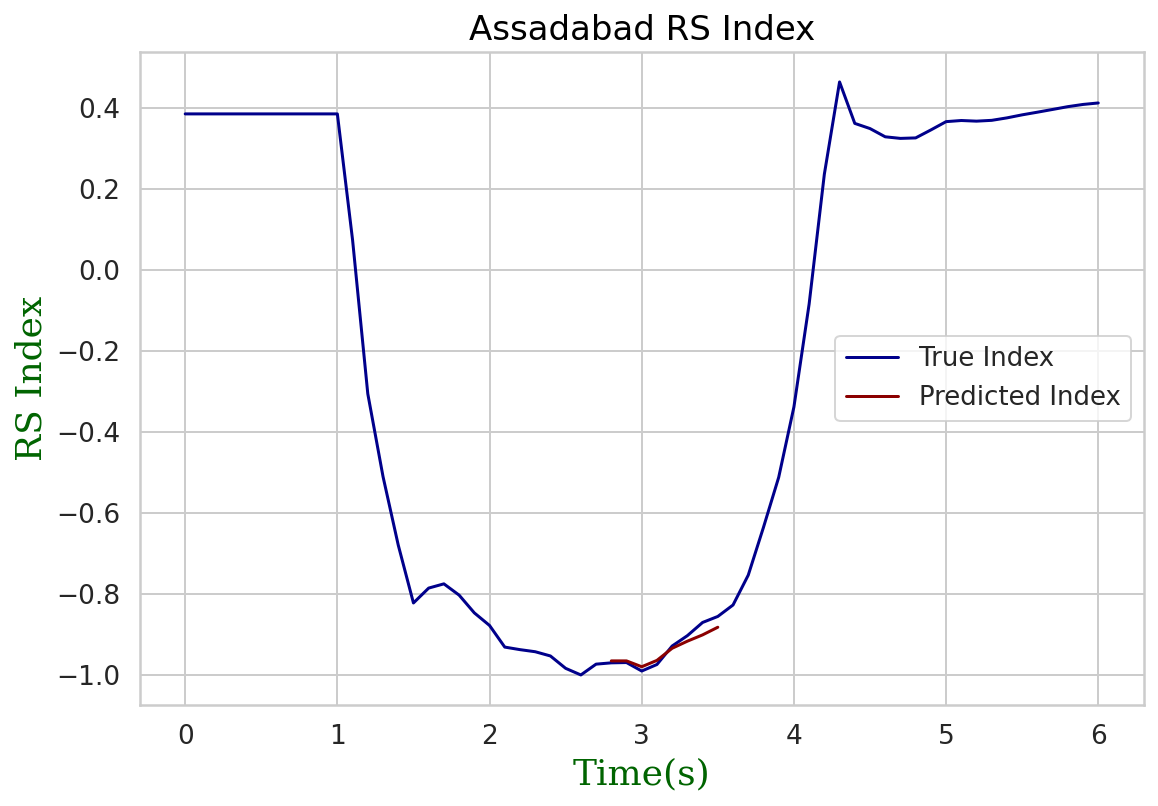

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(t[0:61], data[0:61,123], label='True Index', c='darkblue')
plt.plot(t[28:36], Predictions[0], label='Predicted Index',c= 'darkred')

plt.title('Assadabad RS Index', c='black', fontsize = 17)
plt.xlabel('Time(s)', fontdict=font1)
plt.ylabel('RS Index', fontdict=font1)

plt.legend(fontsize = 13, loc=7)
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_sim_7.csv')
data = df.to_numpy()
t = data[:, 0]

In [ ]:
Predictions = []
Rs_JAD = []

for i in range(123, 123+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[27])
    tst_i = torch.tensor(Rs_i[12:30], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)
        

In [ ]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [ ]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+Load_shedding_bus])
Load_shedding_bus

index_rashtkhr3


27

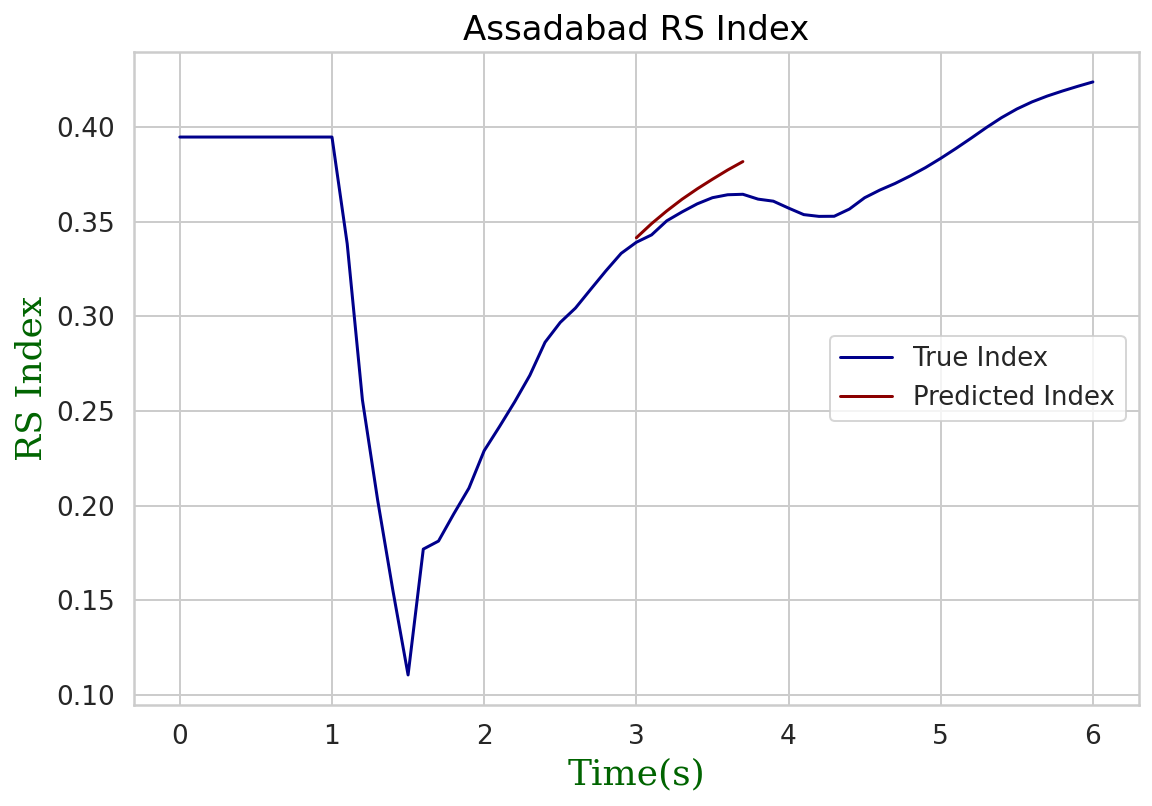

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(t[0:61], data[0:61,142], label='True Index', c='darkblue')
plt.plot(t[30:38], Predictions[19], label='Predicted Index',c= 'darkred')

plt.title('Assadabad RS Index', c='black', fontsize = 17)
plt.xlabel('Time(s)', fontdict=font1)
plt.ylabel('RS Index', fontdict=font1)

plt.legend(fontsize = 13, loc=7)
plt.show()

No handles with labels found to put in legend.


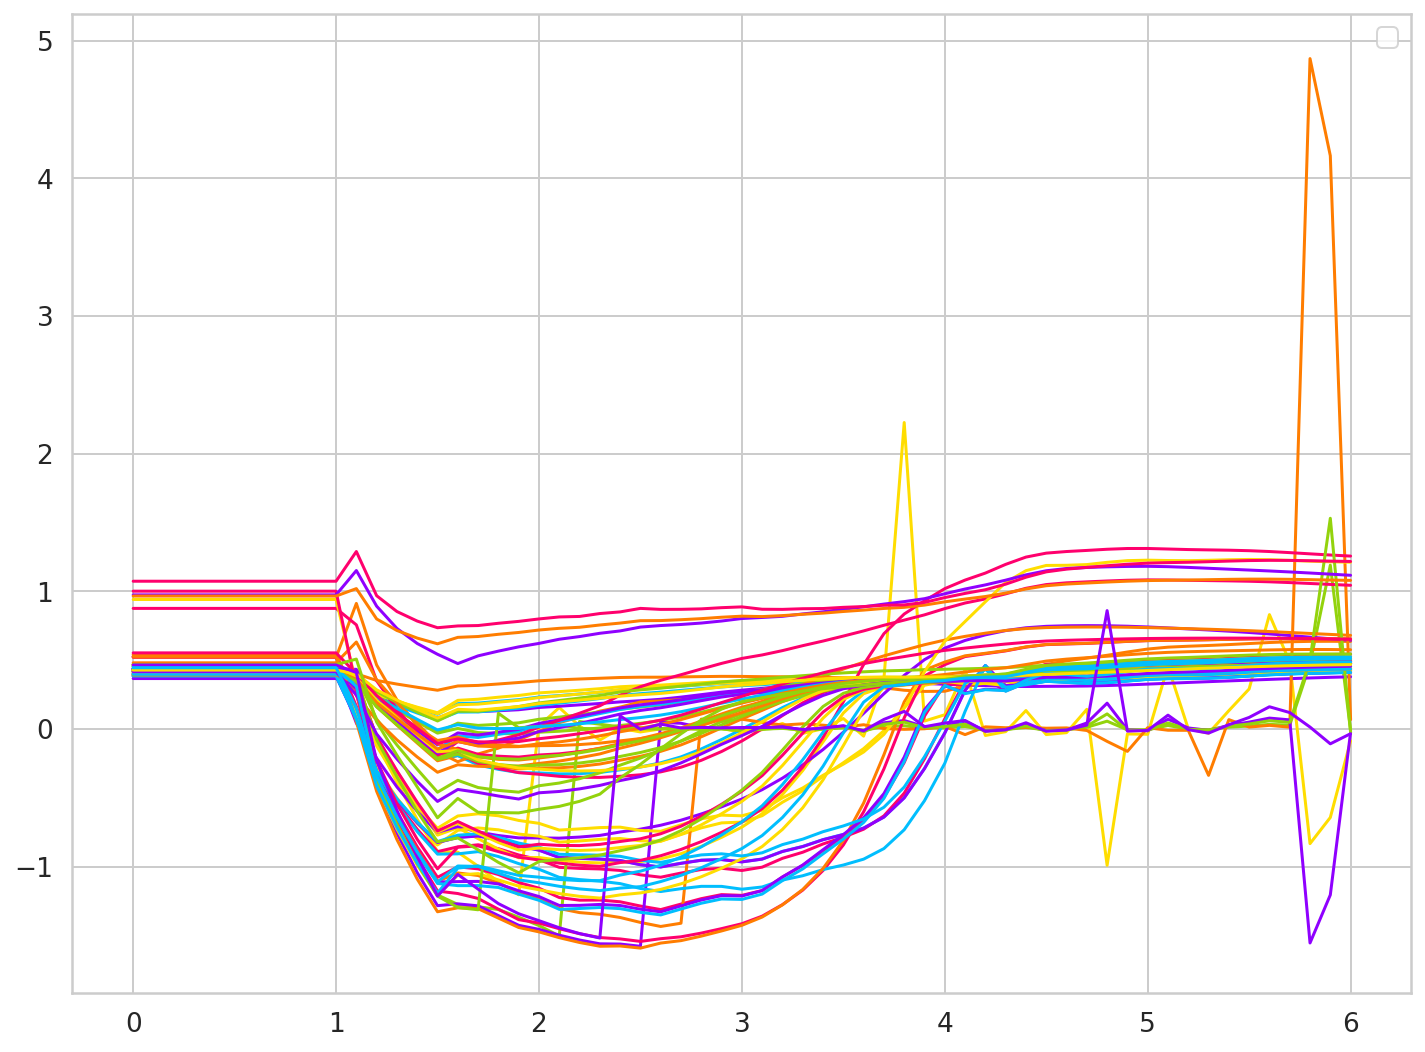

In [ ]:
plt.figure(figsize=(12,9))

for i in range(123, 123+61, 1):
    plt.plot(t[0:61], data[0:61,i])#, label= df.columns[i])

plt.legend()


# stable

In [15]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_stable.csv')
data = df.to_numpy()
t = data[:, 0]

In [16]:
Predictions = []
Rs_JAD = []

for i in range(123+61, 123+61+61, 1):

    Rs_i = data[:, i]
    Rs_JAD.append(Rs_i[17])
    tst_i = torch.tensor(Rs_i[0:18], dtype=torch.float32).reshape(1,18,1).to('cuda')

    preds_i = []
    with torch.no_grad():
    
        pred = network(tst_i)
        preds_i.append(pred.squeeze().item())
        #print(preds)

        for i in range(7):
            tst_i = torch.roll(tst_i, -1, 1)
            tst_i[0,17,0] = pred.squeeze().item()
            #print(tst)
            pred = network(tst_i)
            preds_i.append(pred.squeeze().item())
    
    Predictions.append(preds_i)
        

In [17]:
Ri = []

for i in range (61):

    Ri.append(0.6*((Predictions[i][-1] - Rs_JAD[i])/0.8) + 0.4*Rs_JAD[i])
Ri = np.array(Ri)

In [18]:
print(df.columns[123+61])

index_asadabad3


In [19]:
Load_shedding_bus = np.argmin(Ri)
print(df.columns[123+61+Load_shedding_bus])
Load_shedding_bus

index_tabas3


40

In [13]:
Ri

array([ 0.03382093, -0.6666895 ,  0.21688847, -0.01763497, -0.83414732,
        0.21396249,  0.1783032 , -0.09772387,  0.24887645, -0.0627637 ,
        0.20285212,  0.35871997,  0.22754113,  0.24817314, -0.18231277,
        0.15063347,  0.19732493, -0.09760553,  0.22834453,  0.23088495,
        0.18888571,  0.22980824,  0.25419655,  0.0310998 ,  0.27892   ,
        0.25587535,  0.40171095, -0.17817943,  0.2229982 ,  0.25705511,
       -0.16779939,  0.18324405,  0.00941631,  0.45053673,  0.25305316,
       -0.36796319,  0.0734086 ,  0.51441052,  0.18521655,  0.5783974 ,
       -0.86479148,  0.35562086,  0.27633756, -0.02352755,  0.19877897,
       -0.01885061, -0.32923784,  0.26261041,  0.21075298,  0.16418106,
        0.25134453,  0.32299021,  0.24047957,  0.23095788, -0.45765469,
        0.23578595,  0.39740235,  0.40999716,  0.21172464, -0.11002291,
        0.12102783])

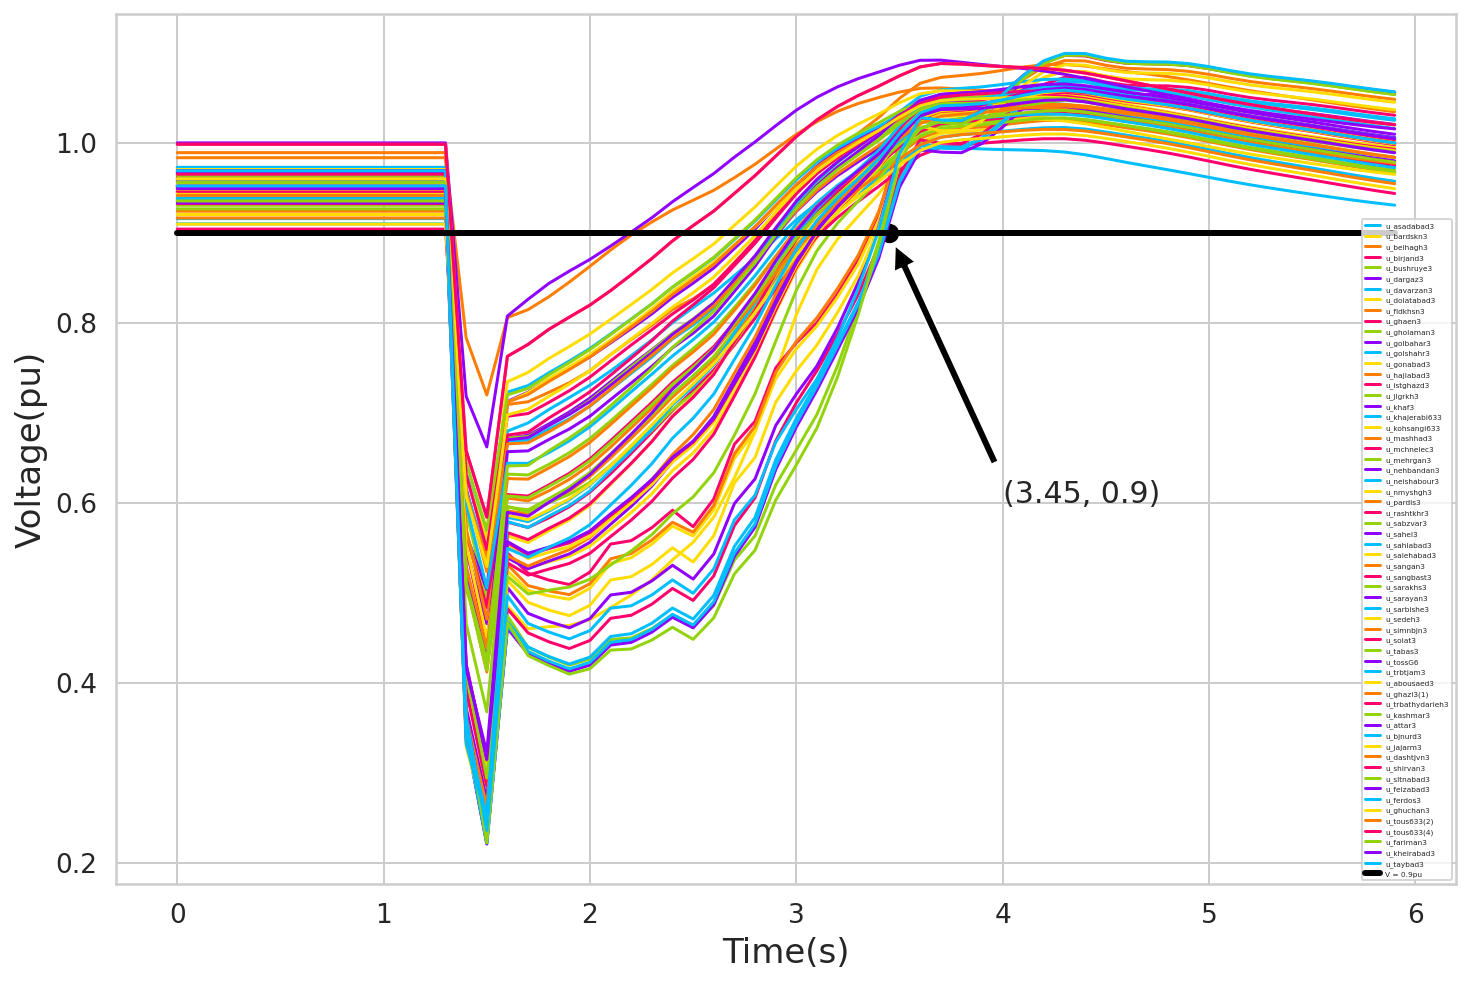

In [23]:
plt.figure(figsize=(12,8))

for i in range(1, 123+61, 3):
    plt.plot(t[0:61], data[0:61,i], label=df.columns[i])


plt.annotate('(3.45, 0.9)', xy =(3.45, 0.9),
                xytext =(4, 0.6),  fontsize=15 ,
                arrowprops = dict(facecolor ='black',
                 shrink = 0.05))

plt.plot(t[0:61], 0.9*np.ones((60)), c='black', label='V = 0.9pu',  linewidth=3)
plt.scatter(3.45, 0.9, c='black', s=75)
plt.xlabel('Time(s)', fontsize=17)
plt.ylabel('Voltage(pu)', fontsize=17)
plt.legend(fontsize=3.7)
plt.savefig('stable_voltage.png', format='png' ,dpi=1200)

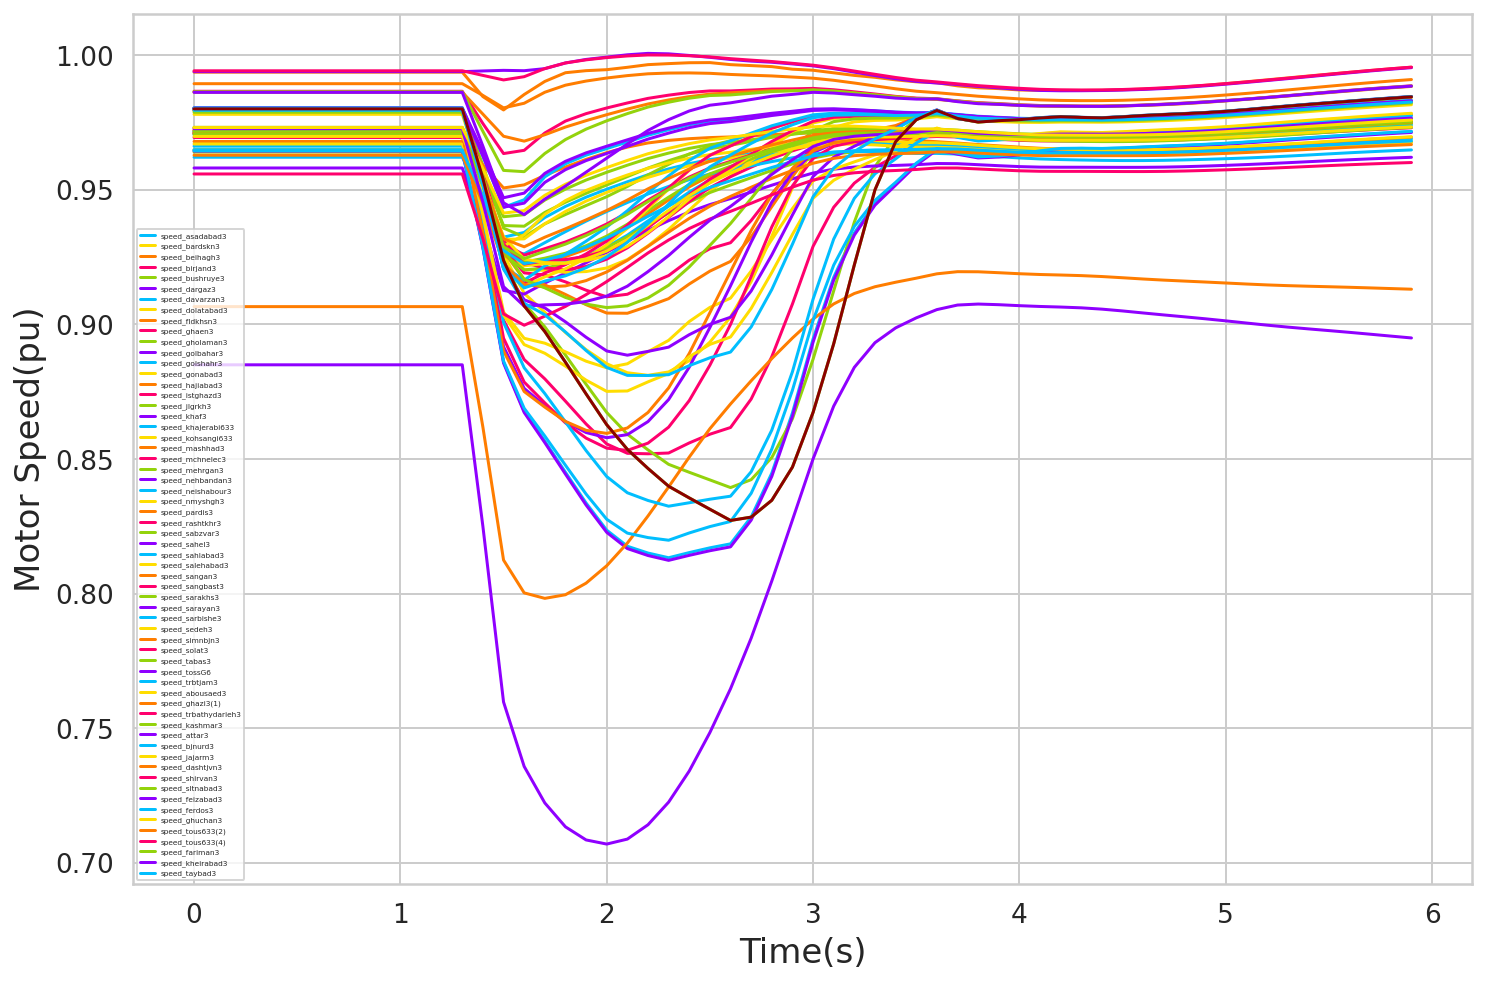

In [24]:
plt.figure(figsize=(12,8))

for i in range(3, 123+61, 3):
    plt.plot(t[0:61], data[0:61,i], label=df.columns[i])


plt.xlabel('Time(s)', fontsize=17)
plt.ylabel('Motor Speed(pu)', fontsize=17)
plt.plot(t[0:61], data[0:61,123], c='darkred')
plt.legend(fontsize=3.7)
plt.savefig('stable_speed.png', format='png' ,dpi=1200)

In [26]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_stable2.csv')
data = df.to_numpy()
t = data[:, 0]

In [27]:
print(df.columns[121])

u_tabas3


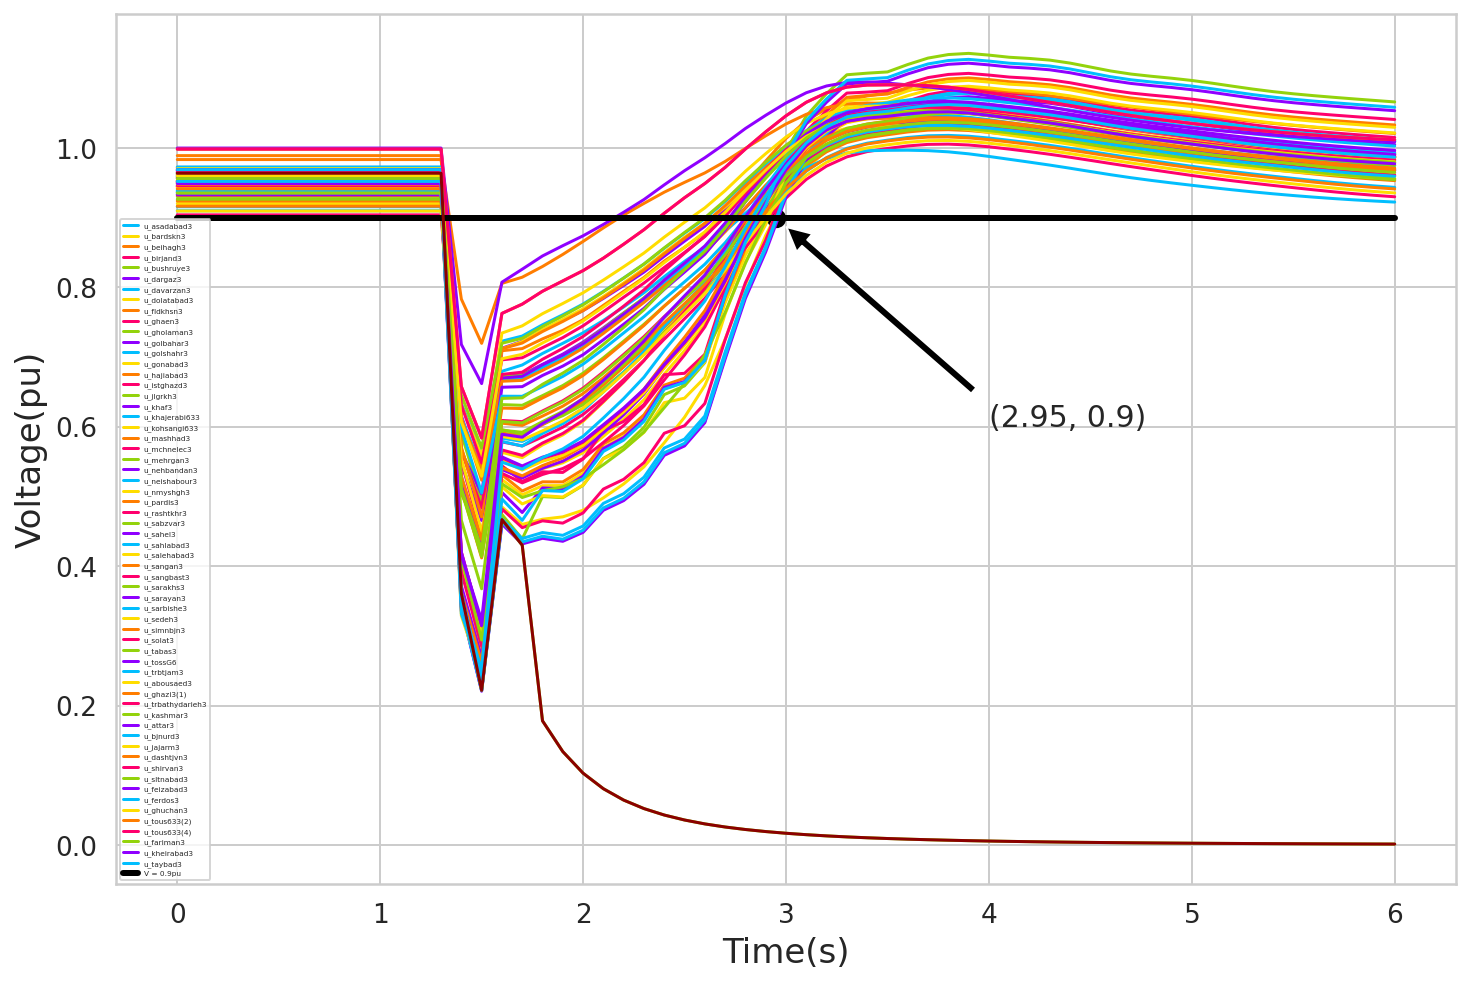

In [30]:
plt.figure(figsize=(12,8))

for i in range(1, 123+61, 3):
    plt.plot(t[0:61], data[0:61,i], label=df.columns[i])


plt.annotate('(2.95, 0.9)', xy =(2.95, 0.9),
                xytext =(4, 0.6),  fontsize=15 ,
                arrowprops = dict(facecolor ='black',
                 shrink = 0.05))

plt.plot(t[0:61], 0.9*np.ones((61)), c='black', label='V = 0.9pu', linewidth=3)
plt.scatter(2.95, 0.9, c='black', s=75)
plt.xlabel('Time(s)', fontsize=17)
plt.ylabel('Voltage(pu)', fontsize=17)
plt.plot(t[0:61], data[0:61,121], c='darkred')
plt.legend(fontsize=3.7)
plt.savefig('stable_voltage2.png', format='png' ,dpi=1200)

In [ ]:
#plt.plot(t[0:61], data[0:61,121])
plt.plot(t[0:61], data[0:61,121])

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/final_stable3.csv')
data = df.to_numpy()
t = data[:, 0]

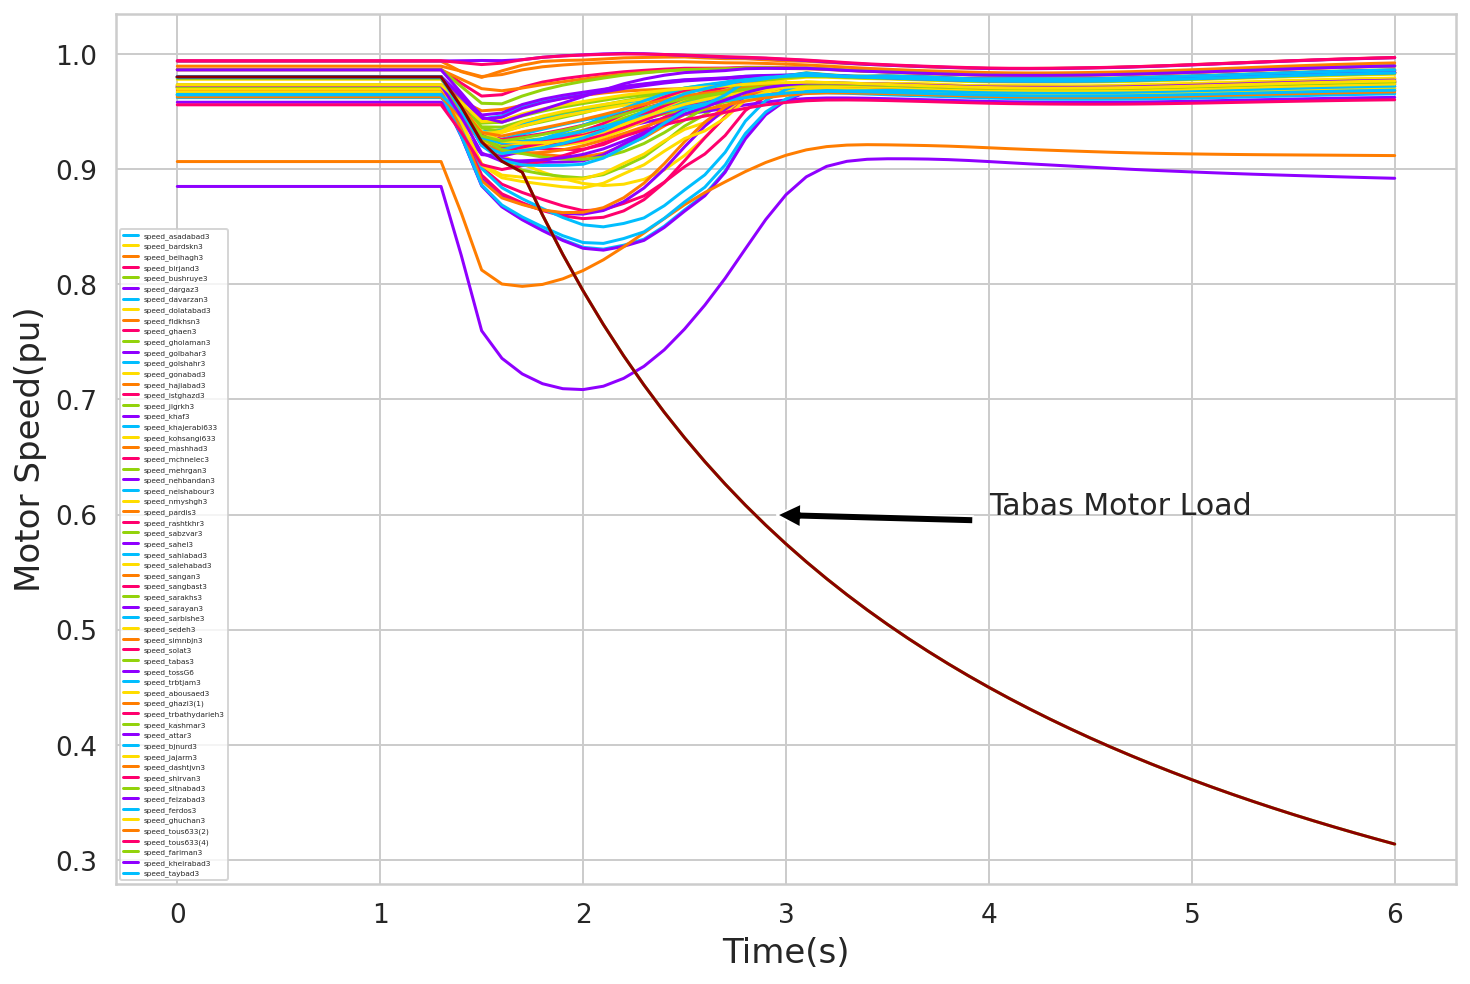

In [32]:
plt.figure(figsize=(12,8))

for i in range(3, 123+61, 3):
    plt.plot(t[0:61], data[0:61,i], label=df.columns[i])


plt.annotate('Tabas Motor Load', xy =(2.9, 0.6),
                xytext =(4, 0.6),  fontsize=15 ,
                arrowprops = dict(facecolor ='black',
                 shrink = 0.05))

plt.xlabel('Time(s)', fontsize=17)
plt.ylabel('Motor Speed(pu)', fontsize=17)
plt.plot(t[0:61], data[0:61,123], c='darkred')
plt.legend(fontsize=3.7)
plt.savefig('stable_speed2.png', format='png' ,dpi=1200)

(-1.0, 1.0)

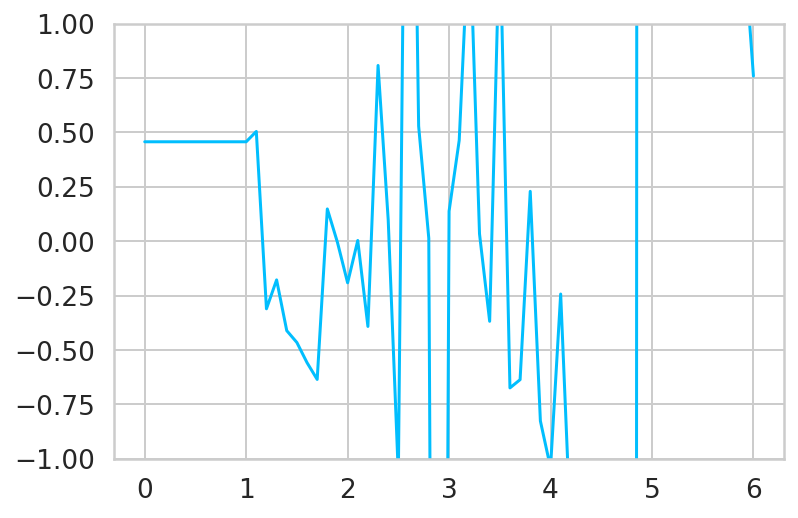

In [ ]:
plt.plot(t[0:61], data[0:61,123+61+Load_shedding_bus])
plt.ylim(-1,1)